<hr style="height:2px;">

# Demo: Training data generation for isotropic reconstruction of Zebrafish retina

This notebook demonstrates training data generation for an isotropic reconstruction task, where the anisotropic distortions along the undersampled Z axis are simulated from isotropic 2D slices.

Note that training data can be created from existing acquisitions.

We will use a single Retina stack for training data generation, whereas in your application you should aim to use stacks from different developmental timepoints to ensure a well trained model. 

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some, axes_dict
from csbdeep.io import save_training_data
from csbdeep.data import RawData, create_patches
from csbdeep.data.transform import anisotropic_distortions

<hr style="height:2px;">

# Download example data

First we download some example data, consisting of a single 3D Zebrafish retina stack.

In [2]:
download_and_extract_zip_file (
    url       = 'http://csbdeep.bioimagecomputing.com/example_data/retina.zip',
    targetdir = 'data',
)

Files missing, downloading... extracting... done.

data:
- retina
- retina/cropped_farred_RFP_GFP_2109175_2color_sub_10.20.tif


We plot XY and XZ slices of the training stack:

In [6]:
x = imread('data/retina/cropped_farred_RFP_GFP_2109175_2color_sub_10.20.tif')
subsample = 10.2
print('image size         =', x.shape)
print('Z subsample factor =', subsample)

plt.figure(figsize=(16,15))
plot_some(np.moveaxis(x,1,-1)[[5,-5]],
          title_list=[['XY slice','XY slice']],
          pmin=2,pmax=99.8);

plt.figure(figsize=(16,15))
plot_some(np.moveaxis(np.moveaxis(x,1,-1)[:,[50,-50]],1,0),
          title_list=[['XZ slice','XZ slice']],
          pmin=2,pmax=99.8, aspect=subsample);

image size         = (35, 2, 768, 768)
Z subsample factor = 10.2


/home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/csbdeep/utils/plot_utils.py:79: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(map(to_color,a)) if 1 < a.shape[-1] <= 3 else a


<hr style="height:2px;">

# Generate training data for isotropic CARE

We first need to create a `RawData` object, which defines how to get pairs of images and the semantics of each axis (e.g. which one is considered a color channel, etc.).

In contrast to the standard CARE approach (e.g. [3D denoising](../denoising3D/1_datagen.ipynb)), we don't have pairs of low/high-SNR images here, just a single image.

Nevertheless, we can use `RawData.from_folder` and simply indicate the same folder as both source and target.  
We also set `axes = 'ZCYX'` to indicate the semantic order of the image axes. 

In [7]:
raw_data = RawData.from_folder (
    basepath    = 'data',
    source_dirs = ['retina'],
    target_dir  = 'retina',
    axes        = 'ZCYX',
)

Furthermore, we must define how to modify XY slices to mimic the axial distortions of a real microscope as closely as possible. To that end, we define a `Transform` object that will take our `RawData` as input and return the modified image. Here, we use `anisotropic_distortions` to accomplish this.

The most important parameters are the subsampling factor along Z of the raw data and the PSF of the microscope that should mimic the optical abberations along Z, but now applied to the lateral X axis.

In [8]:
anisotropic_transform = anisotropic_distortions (
    subsample = 10.2,
    psf       = np.ones((3,3))/9, # use the actual PSF here
    psf_axes  = 'YX',
)

From the raw image stack and its synthetically distorted copy, we now generate corresponding patches. As a general rule, use a patch size that is a power of two along XYZT, or at least divisible by 8.  
Typically, you should use more patches the more trainings stacks you have. By default, patches are sampled from non-background regions (i.e. that are above a relative threshold), see the documentation of `create_patches` for details.

Note that returned values `(X, Y, XY_axes)` by `create_patches` are not to be confused with the image axes X and Y.  
By convention, the variable name `X` (or `x`) refers to an input variable for a machine learning model, whereas `Y` (or `y`) indicates an output variable.

In [19]:
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (1,2,128,128),
    n_patches_per_image = 512,
    transforms          = [anisotropic_transform],
)

    1 raw images x    1 transformations   =     1 images
    1 images     x  512 patches per image =   512 patches in total
Input data:
data: target='retina', sources=['retina'], axes='ZCYX', pattern='*.tif*'
Transformations:
1 x Anisotropic distortion (along X axis)
Patch size:
1 x 2 x 128 x 128


  0%|          | 0/1 [00:00<?, ?it/s]/home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/csbdeep/data/transform.py:252: UserWarning: applying same psf to every channel of the image.
  warnings.warn('applying same psf to every channel of the image.')
100%|██████████| 1/1 [00:17<00:00, 17.39s/it]


In [20]:
print(XY_axes)
print(X.shape)

SCZYX
(512, 2, 1, 128, 128)


In [21]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

shape of X,Y = (512, 2, 1, 128, 128)
axes  of X,Y = SCZYX


Since the isotropic CARE model operates on 2D (+ channel) images, we need to remove the (singleton) Z axis before saving the training data.

In [22]:
z = axes_dict(XY_axes)['Z']
z

2

In [23]:
X = np.take(X,0,axis=z)
Y = np.take(Y,0,axis=z)
XY_axes = XY_axes.replace('Z','')

In [24]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

shape of X,Y = (512, 2, 128, 128)
axes  of X,Y = SCYX


In [25]:
save_training_data('data/my_training_data.npz', X, Y, XY_axes)

## Show

This shows some of the generated patch pairs (odd rows: *source*, even rows: *target*)

/home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/csbdeep/utils/plot_utils.py:79: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(map(to_color,a)) if 1 < a.shape[-1] <= 3 else a


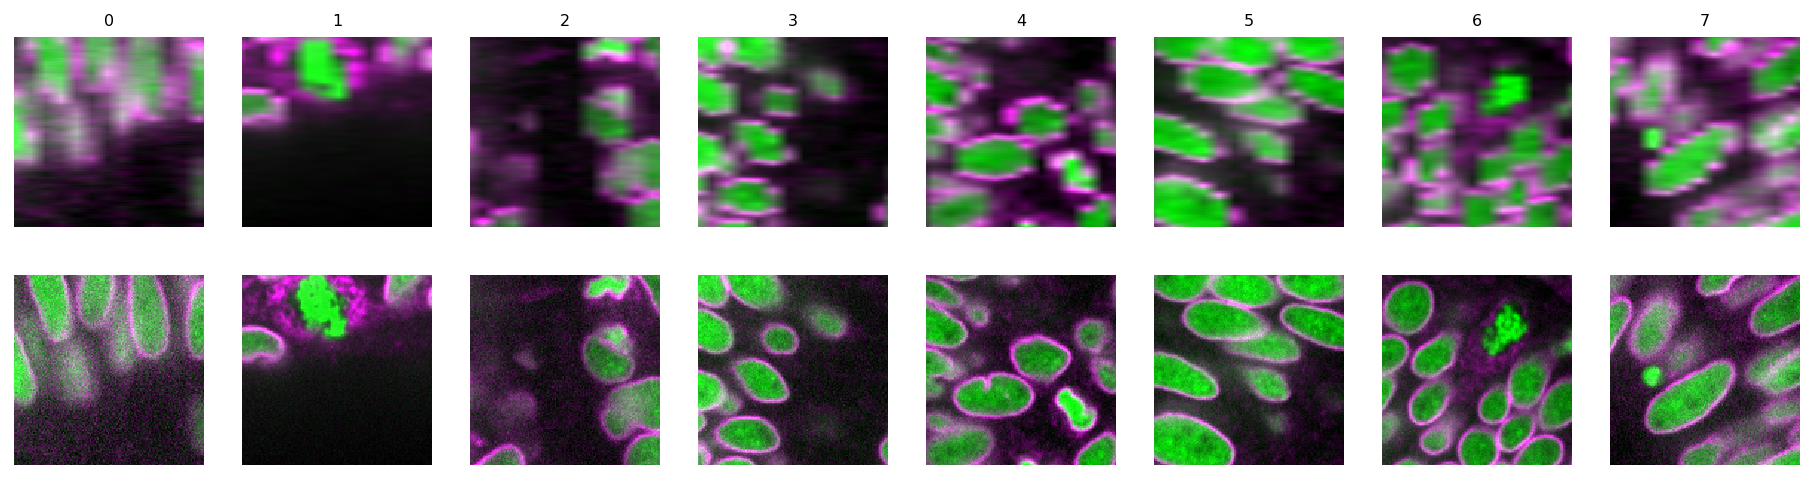

In [26]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1))
    plot_some(np.moveaxis(X[sl],1,-1),np.moveaxis(Y[sl],1,-1),title_list=[np.arange(sl.start,sl.stop)])
    plt.show()
None;